# Welcome to torchvision's new video API

Here, we're going to examine the capabilities of the new video API, together with the examples on how to build datasets and more. 

### Table of contents
1. Introduction: building a new video object and examining the properties
2. Building a sample `read_video` function
3. Building an example dataset (can be applied to e.g. kinetics400)

In [47]:
import torch, torchvision
torch.__version__, torchvision.__version__

('1.8.0a0+7580962', '0.8.0a0+4db3dc6')

In [48]:
# download the sample video
from torchvision.datasets.utils import download_url
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/WUzgd7C1pWA.mp4?raw=true", ".", "WUzgd7C1pWA.mp4")

100.4%

## 1. Introduction: building a new video object and examining the properties

First we select a video to test the object out. For the sake of argument we're using one from Kinetics400 dataset. To create it, we need to define the path and the stream we want to use. See inline comments for description.  

In [49]:
import torch, torchvision
"""
chosen video statistics:
WUzgd7C1pWA.mp4
  - source: kinetics-400
  - video: H-264 - MPEG-4 AVC (part 10) (avc1)
    - fps: 29.97
  - audio: MPEG AAC audio (mp4a)
    - sample rate: 48K Hz
"""
video_path = "./WUzgd7C1pWA.mp4"

"""
streams are defined in a similar fashion as torch devices. We encode them as strings in a form
of `stream_type:stream_id` where stream_type is a string and stream_id a long int. 

The constructor accepts passing a stream_type only, in which case the stream is auto-discovered.
"""
stream = "video"



video = torchvision.io.VideoReader(video_path, stream)

First, let's get the metadata for our particular video:

In [50]:
video.get_metadata()

{'video': {'duration': [10.9109], 'fps': [29.97002997002997]},
 'audio': {'duration': [10.9], 'framerate': [48000.0]}}

Here we can see that video has two streams - a video and an audio stream. 
Currently available stream types include ``['video', 'audio']``.
Each descriptor consists of two parts: stream type (e.g. 'video') and
a unique stream id (which are determined by video encoding).
In this way, if the video contaner contains multiple
streams of the same type, users can acces the one they want.
If only stream type is passed, the decoder auto-detects first stream
of that type and returns it.

Let's read all the frames from the video stream.
By default, the return value of `next(video_reader)` is a dict containing the following fields.

The return fields are 
- `data` containing a torch.tensor
- `pts` containing a float timestamp of this particular frame. 

In [51]:
# first we select the video stream 
metadata = video.get_metadata()
video.set_current_stream("video:0")

frames = []  # we are going to save the frames here.
ptss = [] # pts is a presentation timestamp in seconds (float) of each frame
for frame in video:
    frames.append(frame['data'])
    ptss.append(frame['pts'])

print("PTS for first five frames ", ptss[:5])
print("Total number of frames: ", len(frames))
approx_nf = metadata['video']['duration'][0] * metadata['video']['fps'][0]
print("We can expect approx: ", approx_nf)
print("Tensor size: ", frames[0].size())

PTS for first five frames  [0.0, 0.033367, 0.066733, 0.1001, 0.133467]
Total number of frames:  327
We can expect approx:  327.0
Tensor size:  torch.Size([3, 256, 340])


Note that selecting zero video stream is equivalent to selecting video stream automatically. I.e. `video:0` and `video` will end up with same results in this case. 

Let's try this for audio. Note that presentation timestamps are different so aligment has to be done carefully. 

In [52]:
metadata = video.get_metadata()
video.set_current_stream("audio")

frames = []  # we are going to save the frames here.
ptss = [] # pts is a presentation timestamp in seconds (float) of each frame
for frame in video:
    frames.append(frame['data'])
    ptss.append(frame['pts'])

print("PTS for first five frames ", ptss[:5])
print("Total number of frames: ", len(frames))
approx_nf = metadata['audio']['duration'][0] * metadata['audio']['framerate'][0]
print("Approx total number of datapoints we can expect: ", approx_nf)
print("Read data size: ", frames[0].size(0) * len(frames))

PTS for first five frames  [0.0, 0.021332999999999998, 0.042667, 0.064, 0.08533299999999999]
Total number of frames:  511
Approx total number of datapoints we can expect:  523200.0
Read data size:  523264


But what if we only want to read certain time segment of the video?

That can be done easily using the combination of our seek function, and the fact that each call to next returns the presentation timestamp of the returned frame in seconds. Given that our implementation relies on python iterators, we can leverage `itertools` to simplify the process and make it more pythonic. 

For example, if we wanted to read ten frames from second second:

In [53]:
import itertools
video.set_current_stream("video")

frames = []  # we are going to save the frames here.

# we seek into a second second of the video
# and use islice to get 10 frames since
for frame, pts in itertools.islice(video.seek(2), 10):
    frames.append(frame)
    
print("Total number of frames: ", len(frames))

Total number of frames:  10


Or if we wanted to read from 2nd to 5th second:

In [54]:
video.set_current_stream("video")

frames = []  # we are going to save the frames here.

# we seek into a second second of the video
video = video.seek(2)
# then we utilize the itertools takewhile to get the 
# correct number of frames
for frame in itertools.takewhile(lambda x: x['pts'] <= 5, video):
    frames.append(frame['data'])

print("Total number of frames: ", len(frames))
approx_nf = (5-2) * video.get_metadata()['video']['fps'][0]
print("We can expect approx: ", approx_nf)
print("Tensor size: ", frames[0].size())

Total number of frames:  90
We can expect approx:  89.91008991008991
Tensor size:  torch.Size([3, 256, 340])


## 2. Building a sample `read_video` function

We can utilize the methods above to build the read video function that follows the same API to the existing `read_video` function 

In [55]:
def example_read_video(video_object, start=0, end=None, read_video=True, read_audio=True):

    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end time should be larger than start time, got "
            "start time={} and end time={}".format(s, e)
        )
    
    video_frames = torch.empty(0)
    video_pts = []
    if read_video:
        video_object.set_current_stream("video")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            video_frames = torch.stack(frames, 0)

    audio_frames = torch.empty(0)
    audio_pts = []
    if read_audio:
        video_object.set_current_stream("audio")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            audio_frames = torch.cat(frames, 0)

    return video_frames, audio_frames, (video_pts, audio_pts), video_object.get_metadata()

In [56]:
vf, af, info, meta = example_read_video(video)
# total number of frames should be 327 for video and 523264 datapoints for audio
print(vf.size(), af.size())

torch.Size([327, 3, 256, 340]) torch.Size([523264, 1])


In [57]:
# you can also get the sequence of audio frames as well
af.size()

torch.Size([523264, 1])

## 3. Building an example randomly sampled dataset (can be applied to training dataest of kinetics400)

Cool, so now we can use the same principle to make the sample dataset. We suggest trying out iterable dataset for this purpose. 

Here, we are going to build

a. an example dataset that reads randomly selected 10 frames of video

In [58]:
# make sample dataest
import os
os.makedirs("./dataset", exist_ok=True)
os.makedirs("./dataset/1", exist_ok=True)
os.makedirs("./dataset/2", exist_ok=True)

In [59]:
# download the videos 
from torchvision.datasets.utils import download_url
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/WUzgd7C1pWA.mp4?raw=true", "./dataset/1", "WUzgd7C1pWA.mp4")
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/RATRACE_wave_f_nm_np1_fr_goo_37.avi?raw=true", "./dataset/1", "RATRACE_wave_f_nm_np1_fr_goo_37.avi")
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/SOX5yA1l24A.mp4?raw=true", "./dataset/2", "SOX5yA1l24A.mp4")
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/v_SoccerJuggling_g23_c01.avi?raw=true", "./dataset/2", "v_SoccerJuggling_g23_c01.avi")
download_url("https://github.com/pytorch/vision/blob/master/test/assets/videos/v_SoccerJuggling_g24_c01.avi?raw=true", "./dataset/2", "v_SoccerJuggling_g24_c01.avi")

18.4%

100.4%

102.5%

100.9%

101.5%

101.3%

In [60]:
# housekeeping and utilities
import os
import random

import torch
from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t

def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def get_samples(root, extensions=(".mp4", ".avi")):
    _, class_to_idx = _find_classes(root)
    return make_dataset(root, class_to_idx, extensions=extensions)

We are going to define the dataset and some basic arguments. We asume the structure of the FolderDataset, and add the following parameters:
    
1. frame transform: with this API, we can chose to apply transforms on every frame of the video
2. videotransform: equally, we can also apply transform to a 4D tensor
3. length of the clip: do we want a single or multiple frames?

Note that we actually add `epoch size` as using `IterableDataset` class allows us to naturally oversample clips or images from each video if needed. 

In [61]:
class RandomDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, frame_transform=None, video_transform=None, clip_len=16):
        super(RandomDataset).__init__()
        
        self.samples = get_samples(root)
         
        # allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size
        
        self.clip_len = clip_len  # length of a clip in frames
        self.frame_transform = frame_transform  # transform for every frame individually
        self.video_transform = video_transform # transform on a video sequence

    def __iter__(self):
        for i in range(self.epoch_size):
            # get random sample
            path, target = random.choice(self.samples)
            # get video object
            vid = torchvision.io.VideoReader(path, "video")
            metadata = vid.get_metadata()
            video_frames = [] # video frame buffer 
            # seek and return frames
            
            max_seek = metadata["video"]['duration'][0] - (self.clip_len / metadata["video"]['fps'][0])
            start = random.uniform(0., max_seek)
            for frame in itertools.islice(vid.seek(start), self.clip_len):
                video_frames.append(self.frame_transform(frame['data']))
                current_pts = frame['pts']
            # stack it into a tensor
            video = torch.stack(video_frames, 0)
            if self.video_transform:
                video = self.video_transform(video)
            output = {
                'path': path,
                'video': video,
                'target': target,
                'start': start,
                'end': current_pts}
            yield output

Given a path of videos in a folder structure, i.e:
```
dataset:
    -class 1:
        file 0
        file 1
        ...
    - class 2:
        file 0
        file 1
        ...
    - ...
```
We can generate a dataloader and test the dataset. 
            

In [62]:
from torchvision import transforms as t
transforms = [t.Resize((112, 112))]
frame_transform = t.Compose(transforms)

ds = RandomDataset("./dataset", epoch_size=None, frame_transform=frame_transform)

In [63]:
from torch.utils.data import DataLoader
loader = DataLoader(ds, batch_size=12)
d = {"video":[], 'start':[], 'end':[], 'tensorsize':[]}
for b in loader:
    for i in range(len(b['path'])):
        d['video'].append(b['path'][i])
        d['start'].append(b['start'][i].item())
        d['end'].append(b['end'][i].item())
        d['tensorsize'].append(b['video'][i].size())

In [64]:
d

{'video': ['./dataset/2/SOX5yA1l24A.mp4',
  './dataset/1/RATRACE_wave_f_nm_np1_fr_goo_37.avi',
  './dataset/2/v_SoccerJuggling_g23_c01.avi',
  './dataset/2/SOX5yA1l24A.mp4',
  './dataset/2/v_SoccerJuggling_g24_c01.avi'],
 'start': [2.9344678384893816,
  1.6827470772443045,
  3.9380918322335887,
  8.400625043794742,
  0.9696198736175933],
 'end': [3.4367669999999997,
  2.1999999999999997,
  4.471133,
  8.9089,
  1.5014999999999998],
 'tensorsize': [torch.Size([16, 3, 112, 112]),
  torch.Size([16, 3, 112, 112]),
  torch.Size([16, 3, 112, 112]),
  torch.Size([16, 3, 112, 112]),
  torch.Size([16, 3, 112, 112])]}

## Visualisation:
    
example of visualsed video

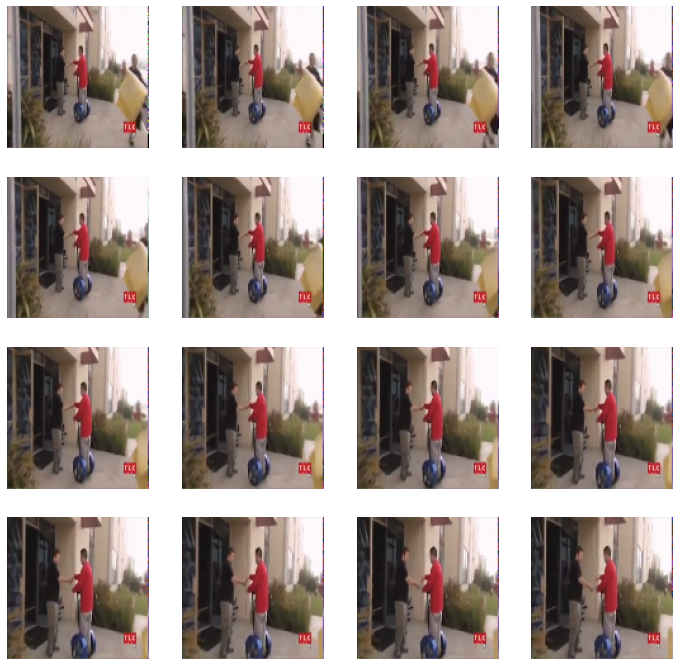

In [69]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(b["video"][0, i, ...].permute(1, 2, 0))
  plt.axis("off")

In [70]:
## Cleanup
import os, shutil
os.remove("./WUzgd7C1pWA.mp4")
shutil.rmtree("./dataset")